In [1]:
# --- Importing Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
import scipy as sp
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm

from numpy.random import uniform
from random import sample
from math import isnan
from joblib import Memory
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
from scipy.stats import f_oneway, shapiro, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tabulate import tabulate
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import f
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from patsy import dmatrices, EvalEnvironment, dmatrix, dmatrices, ModelDesc, Term, EvalFactor
from scipy.stats import chi2_contingency

# ---Libraries Setting ---
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 400
sns.set(rc = {'axes.facecolor': '#FBFBFB', 'figure.facecolor': '#FBFBFB'})
class clr:
    start = '\033[93m'+'\033[1m'
    color = '\033[93m'
    end = '\033[0m'

# Read Data - Empiris

In [2]:
file_path_1 = r"D:\Lainnya\Portofolio\Marketing AB Test\marketing_AB.csv"
df_asli = pd.read_csv(file_path_1, index_col='no')
df_asli.head()

,user id,test group,converted,total ads,most ads day,most ads hour
no,,,,,,
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


# ETL - EDA

## Statistika Deskriptif

In [3]:
# --- Data Preparation ---
summary = {}

summary['Jumlah Observasi'] = len(df_asli)
group_counts = df_asli['test group'].value_counts().to_dict()
summary['Jumlah per Grup'] = group_counts

conversion_rate = df_asli.groupby('test group')['converted'].mean().round(4).to_dict()
summary['Conversion Rate per Grup'] = conversion_rate

avg_ads = df_asli.groupby('test group')['total ads'].mean().round(2).to_dict()
summary['Rata-rata Total Ads per Grup'] = avg_ads
if 'converted_int' not in df_asli.columns:
    df_asli['converted_int'] = df_asli['converted'].astype(int)

desc = df_asli[['total ads', 'most ads hour', 'converted_int']].describe().round(2)
print("📊 Ringkasan Statistik Deskriptif:\n")
for key, value in summary.items():
    print(f"🔹 {key}:")
    if isinstance(value, dict):
        for subkey, subval in value.items():
            print(f"   - {subkey}: {subval}")
    else:
        print(f"   {value}")
    print()
print("📈 Statistik Numerik:\n")
print(tabulate(desc, headers='keys', tablefmt='grid'))

📊 Ringkasan Statistik Deskriptif:

🔹 Jumlah Observasi:
   588101

🔹 Jumlah per Grup:
   - ad: 564577
   - psa: 23524

🔹 Conversion Rate per Grup:
   - ad: 0.0255
   - psa: 0.0179

🔹 Rata-rata Total Ads per Grup:
   - ad: 24.82
   - psa: 24.76

📈 Statistik Numerik:

+-------+-------------+-----------------+-----------------+
|       |   total ads |   most ads hour |   converted_int |
+=======+=============+=================+=================+
| count |   588101    |       588101    |       588101    |
+-------+-------------+-----------------+-----------------+
| mean  |       24.82 |           14.47 |            0.03 |
+-------+-------------+-----------------+-----------------+
| std   |       43.72 |            4.83 |            0.16 |
+-------+-------------+-----------------+-----------------+
| min   |        1    |            0    |            0    |
+-------+-------------+-----------------+-----------------+
| 25%   |        4    |           11    |            0    |
+-------+-----

## Visualisasi Peubah Awal

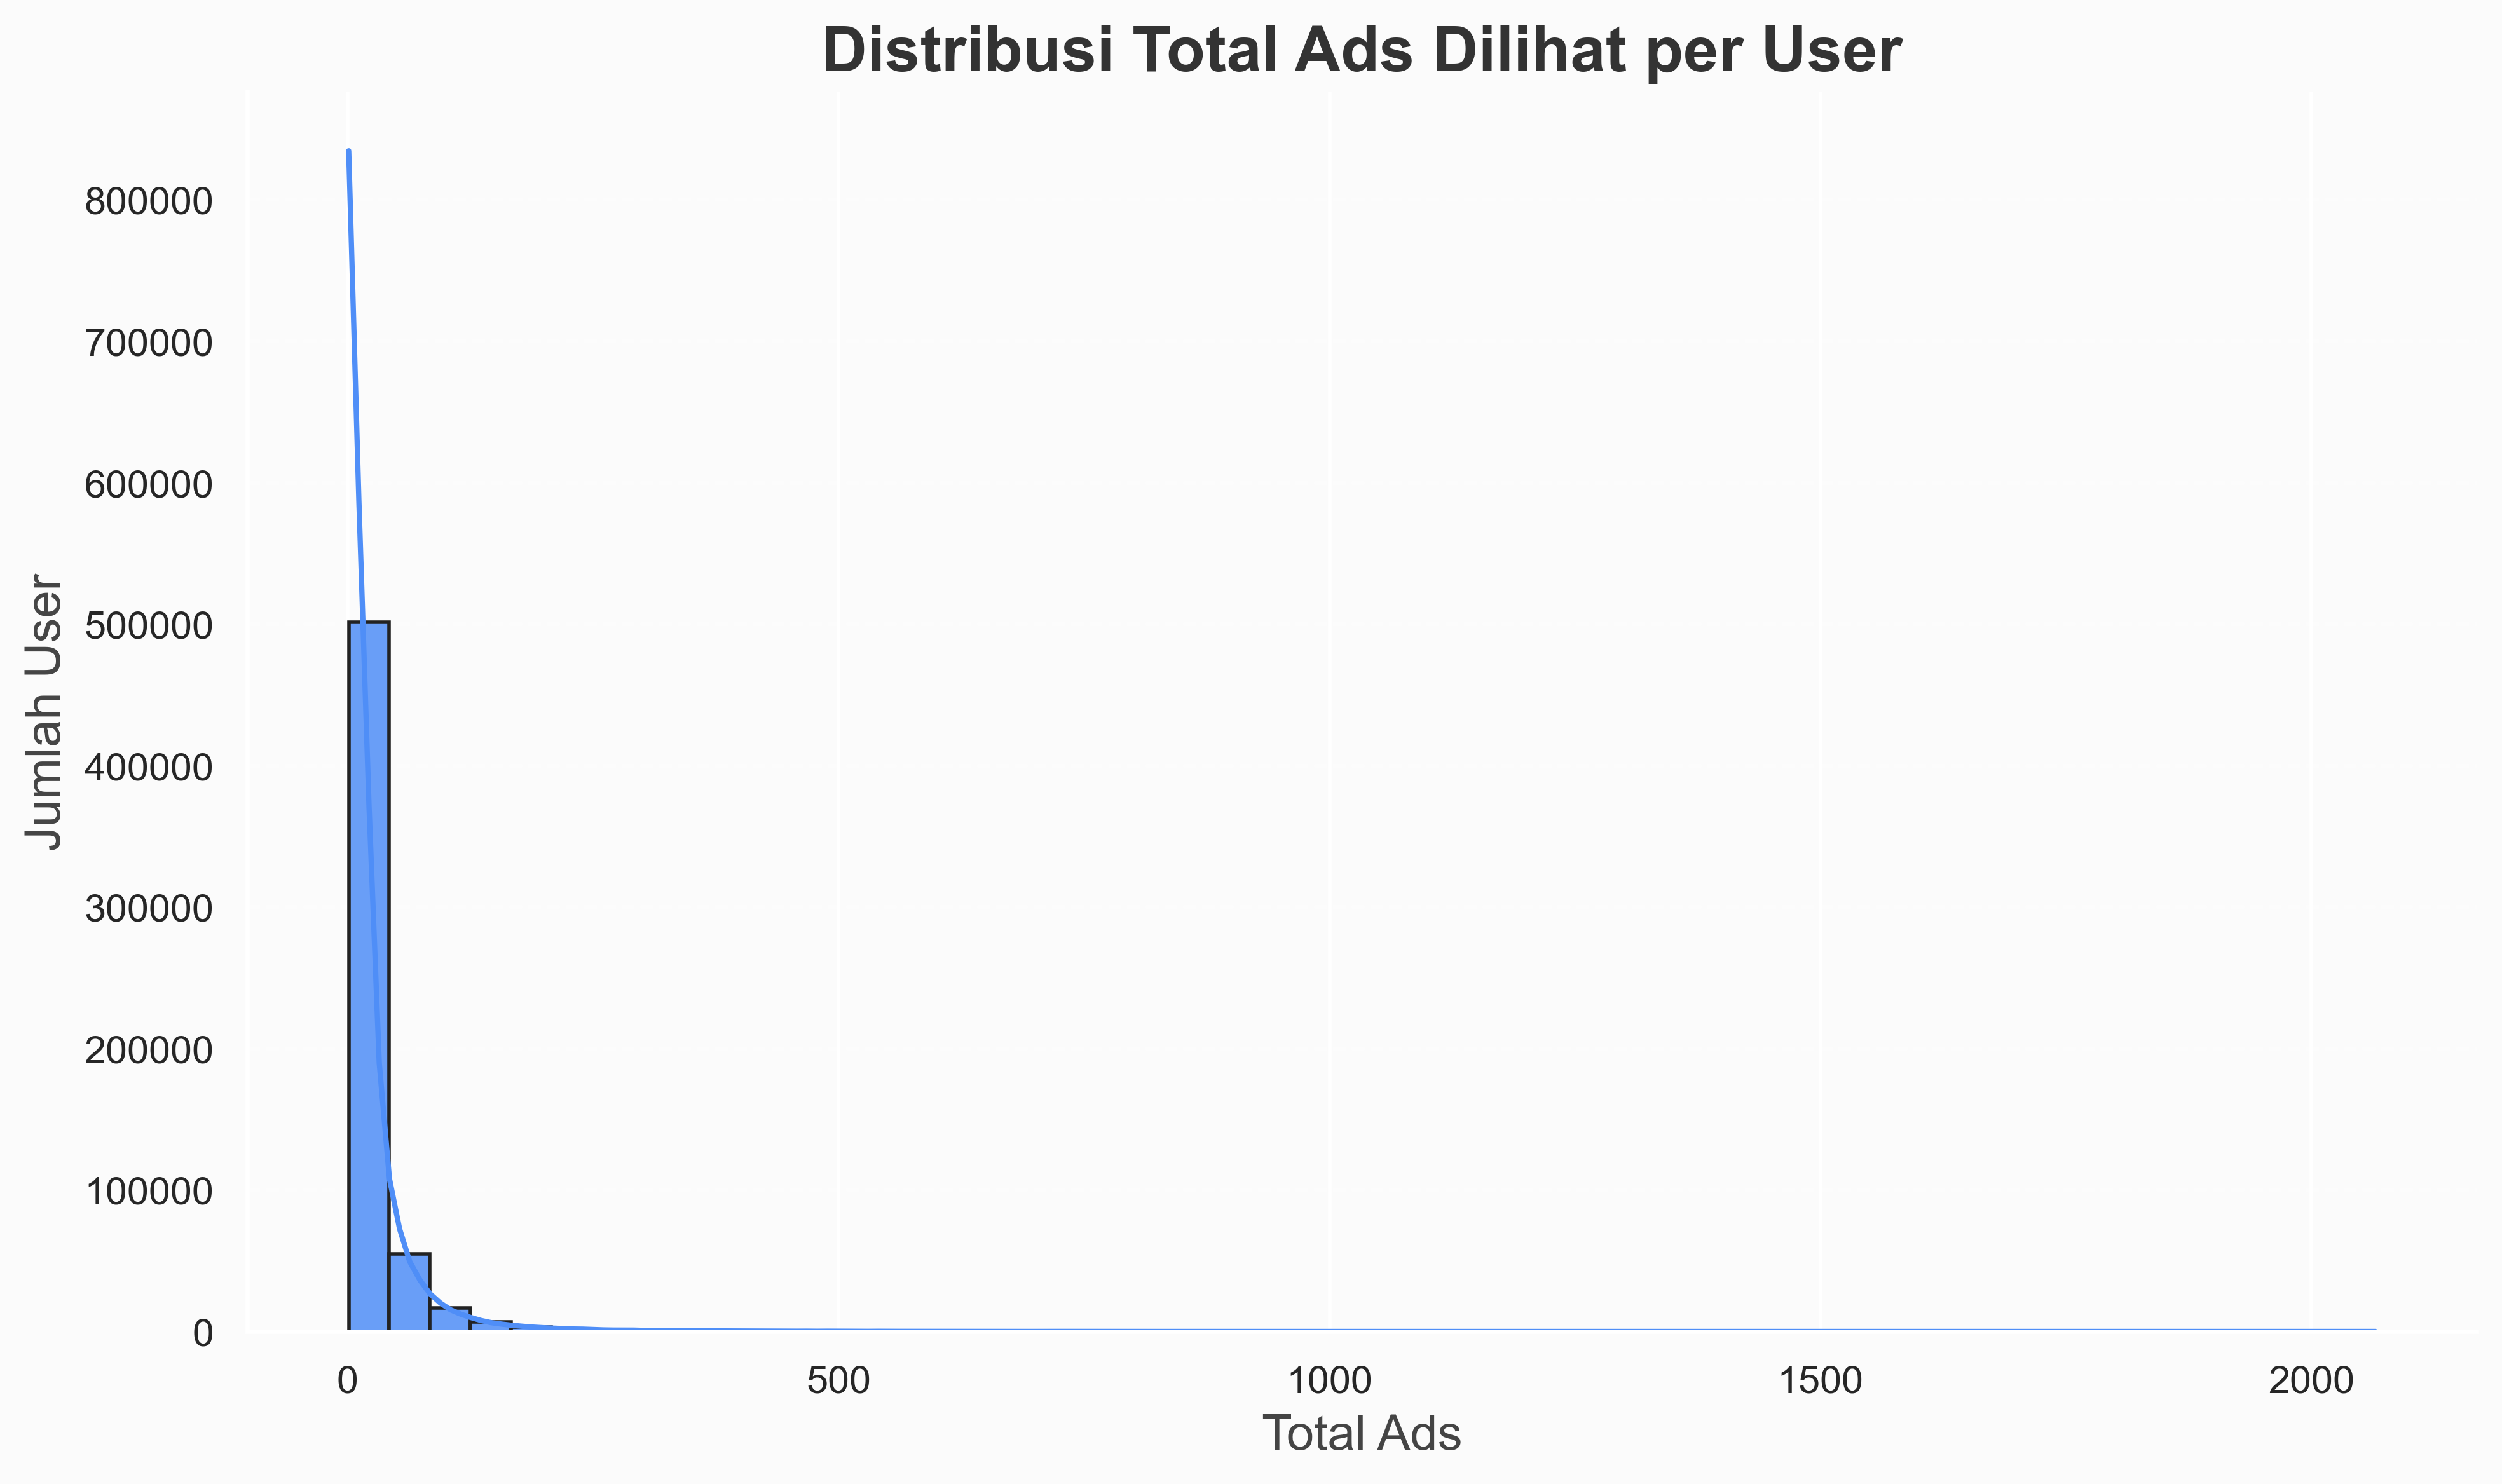

In [4]:
# Sebaran Total Ads dengan visualisasi lebih menarik
plt.figure(figsize=(10, 6))
sns.histplot(
    df_asli['total ads'],
    bins=50,
    kde=True,
    color="#4F8EF7",
    edgecolor="#222",
    alpha=0.85
)
plt.title("Distribusi Total Ads Dilihat per User", fontsize=18, fontweight='bold', color="#333")
plt.xlabel("Total Ads", fontsize=14, color="#444")
plt.ylabel("Jumlah User", fontsize=14, color="#444")
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

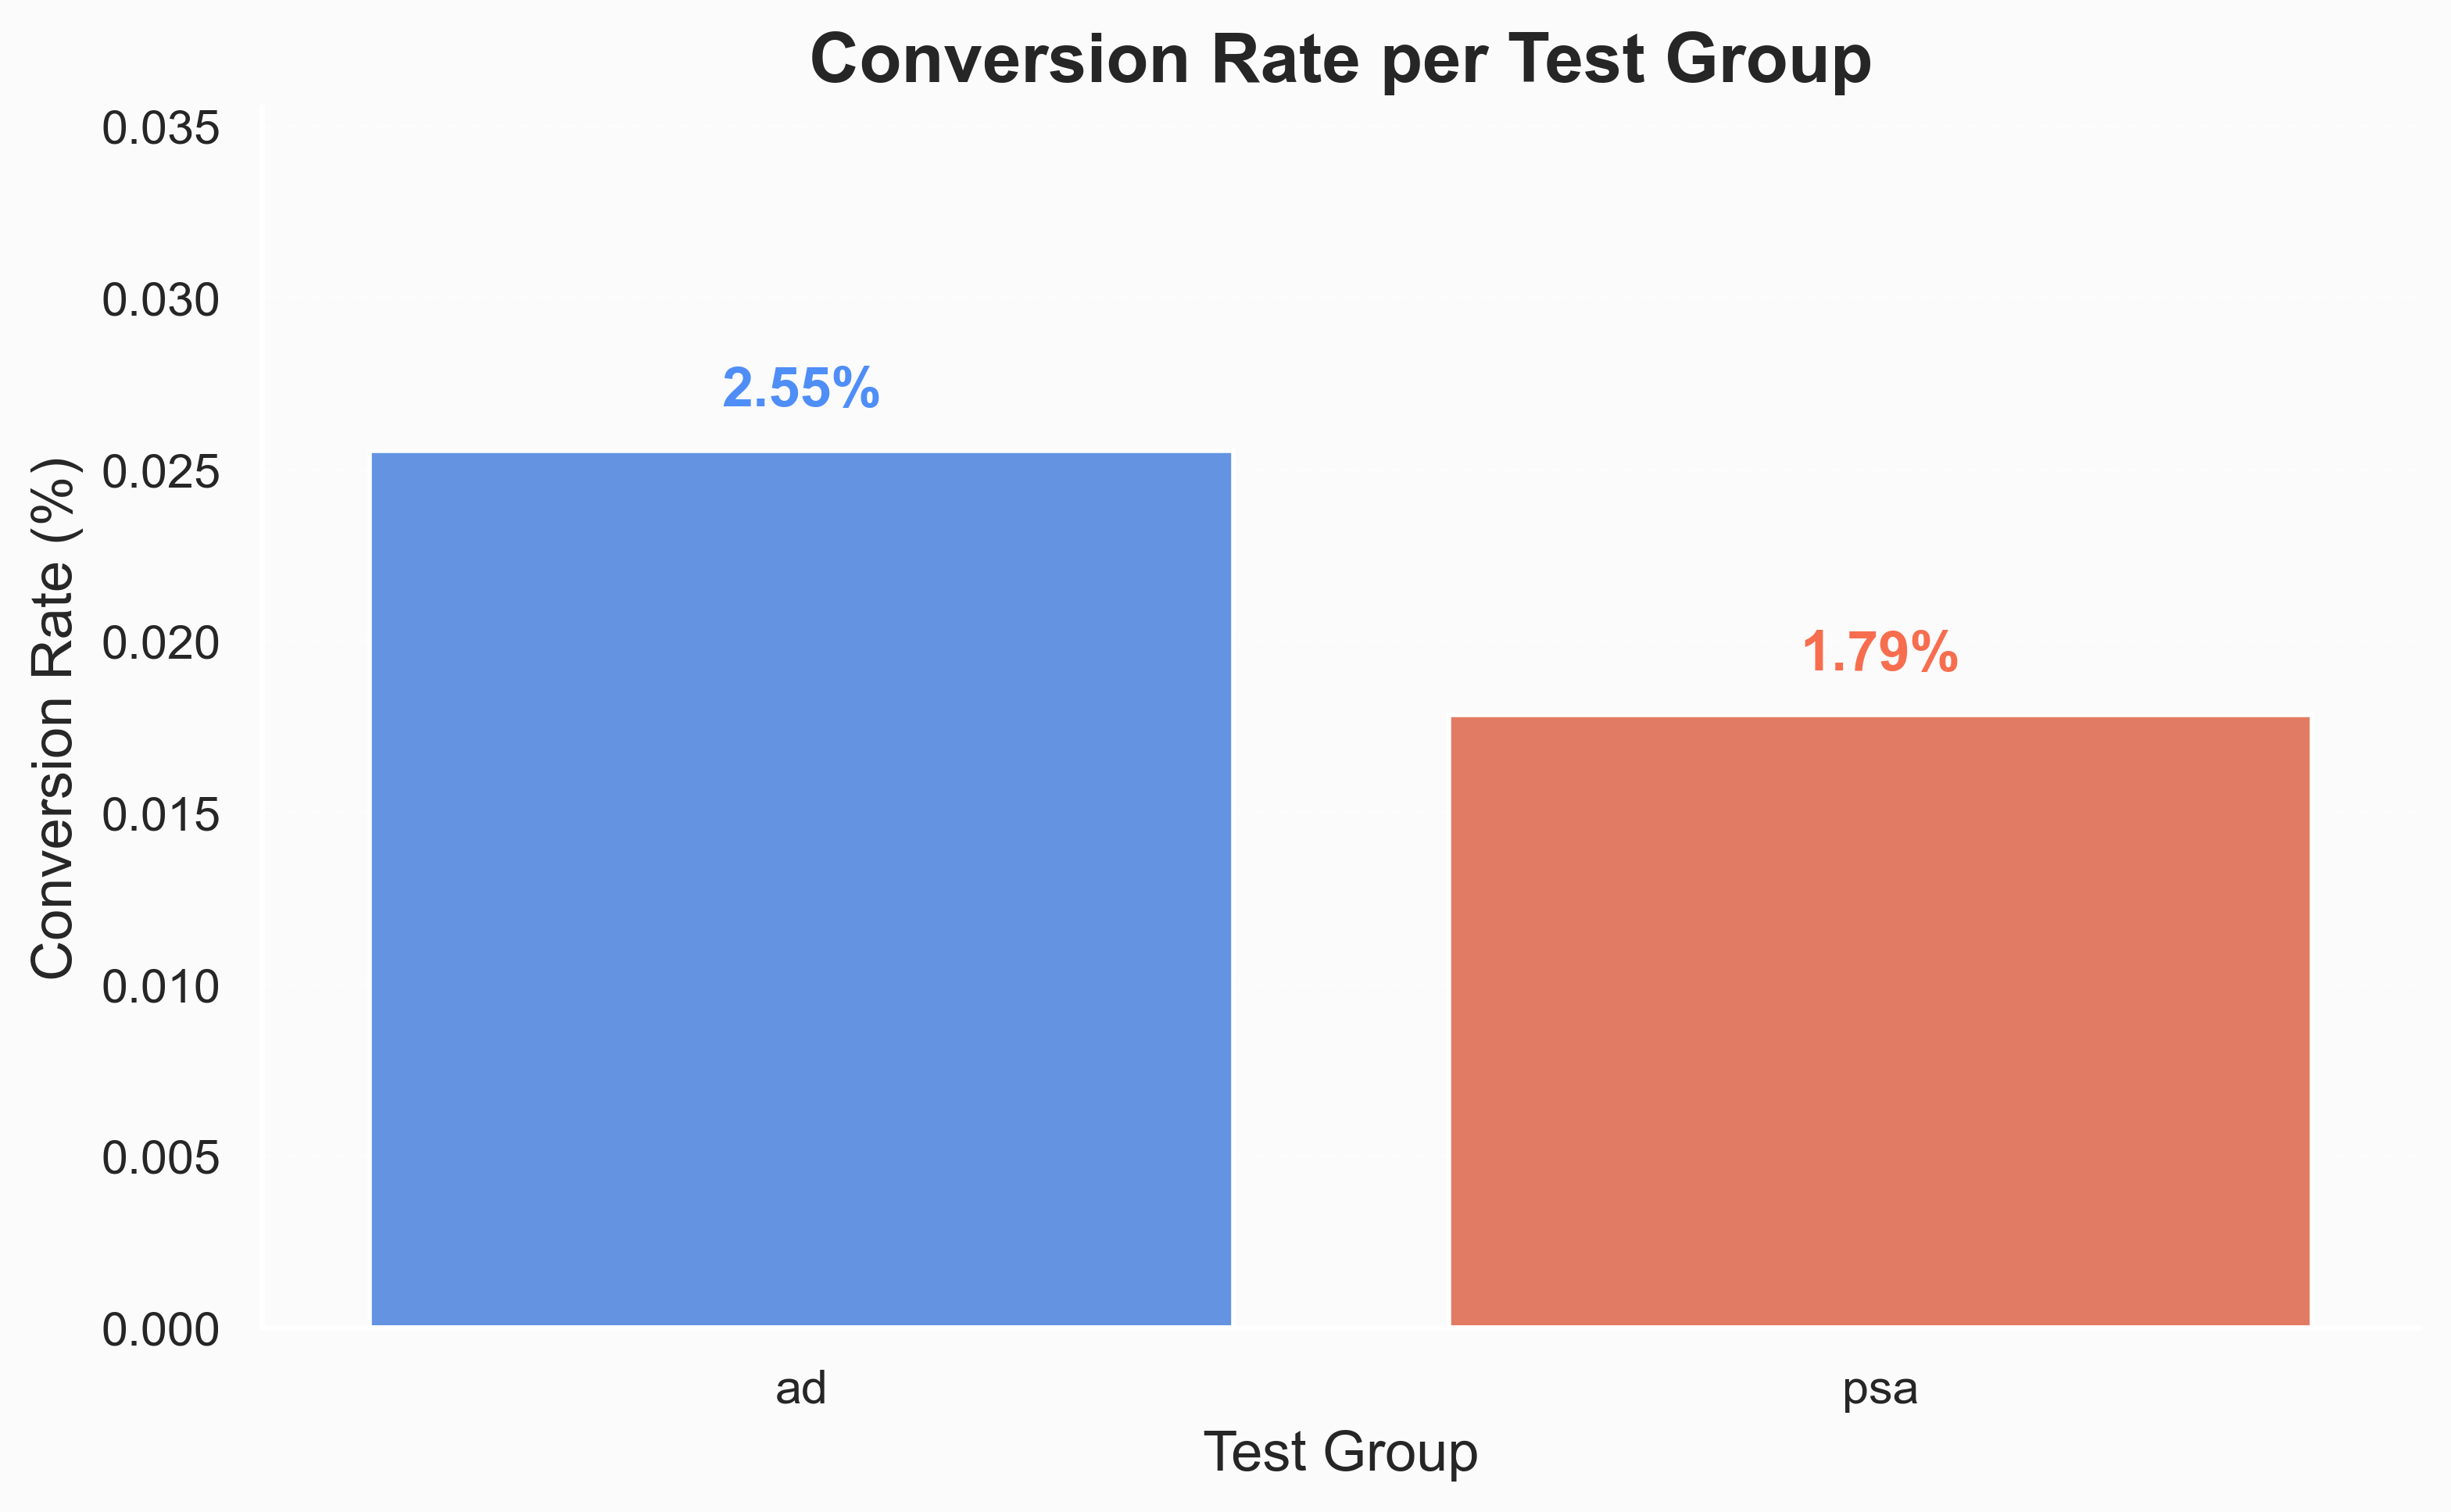

In [5]:
# Conversion Rate per Test Group
conv_rates = df_asli.groupby('test group')['converted'].mean().reset_index()

plt.figure(figsize=(8, 5))
palette = {'ad': '#4F8EF7', 'psa': '#F76E4F'}
ax = sns.barplot(
    x='test group',
    y='converted',
    data=conv_rates,
    palette=palette)
for i, row in conv_rates.iterrows():
    ax.text(
        i, 
        row['converted'] + 0.001, 
        f"{row['converted']*100:.2f}%", 
        ha='center', 
        va='bottom', 
        fontsize=13, 
        fontweight='bold', 
        color=palette[row['test group']])
plt.title("Conversion Rate per Test Group", fontsize=16, fontweight='bold')
plt.xlabel("Test Group", fontsize=13)
plt.ylabel("Conversion Rate (%)", fontsize=13)
plt.ylim(0, conv_rates['converted'].max() + 0.01)
plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

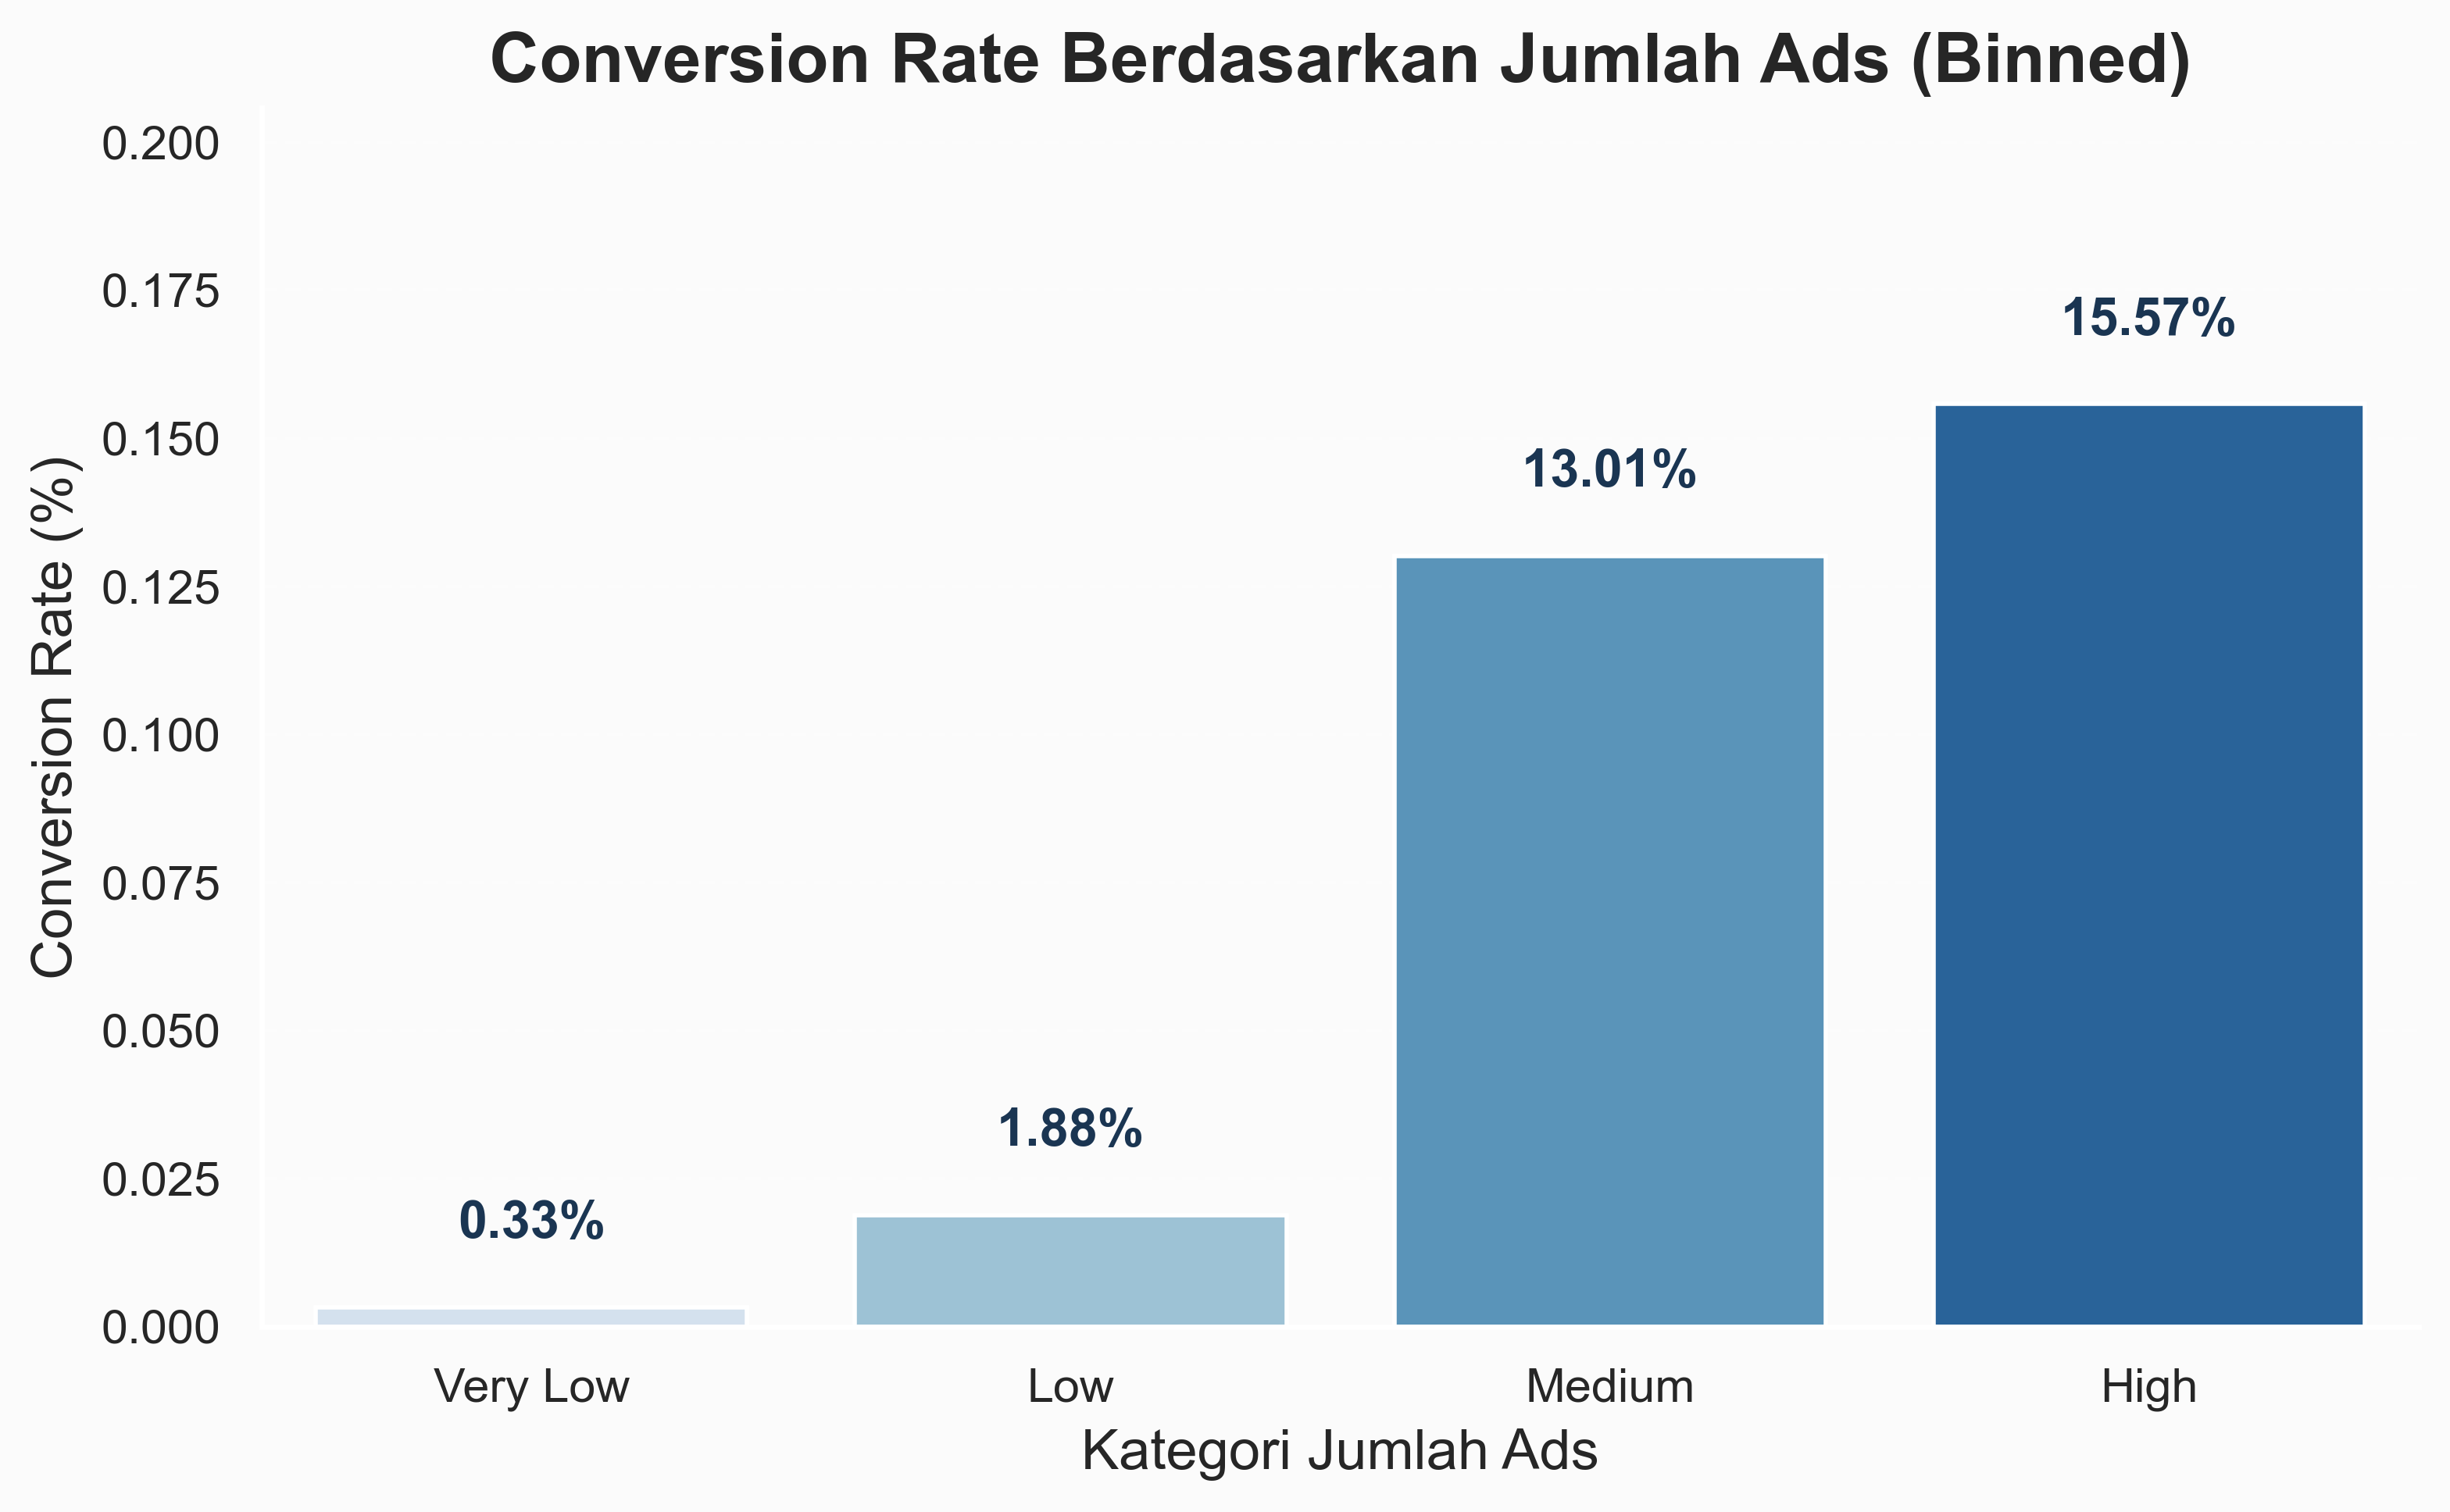

In [6]:
# Conversion Rate per ads_bin
ads_bin_order = ['Very Low', 'Low', 'Medium', 'High']
df_asli['ads_bin'] = pd.cut(
    df_asli['total ads'],
    bins=[-np.inf, 10, 50, 200, np.inf],
    labels=ads_bin_order)

ads_bin_conv = df_asli.groupby('ads_bin')['converted'].mean().reset_index()
plt.figure(figsize=(8, 5))
palette = sns.color_palette("Blues", n_colors=len(ads_bin_order))

ax = sns.barplot(
    x='ads_bin',
    y='converted',
    data=ads_bin_conv,
    order=ads_bin_order,
    palette=palette)
for i, row in ads_bin_conv.iterrows():
    ax.text(
        i, 
        row['converted'] + 0.01, 
        f"{row['converted']*100:.2f}%", 
        ha='center', 
        va='bottom', 
        fontsize=12, 
        fontweight='bold', 
        color='#1a3552')
plt.title("Conversion Rate Berdasarkan Jumlah Ads (Binned)", fontsize=16, fontweight='bold')
plt.xlabel("Kategori Jumlah Ads", fontsize=13)
plt.ylabel("Conversion Rate (%)", fontsize=13)
plt.ylim(0, ads_bin_conv['converted'].max() + 0.05)
plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

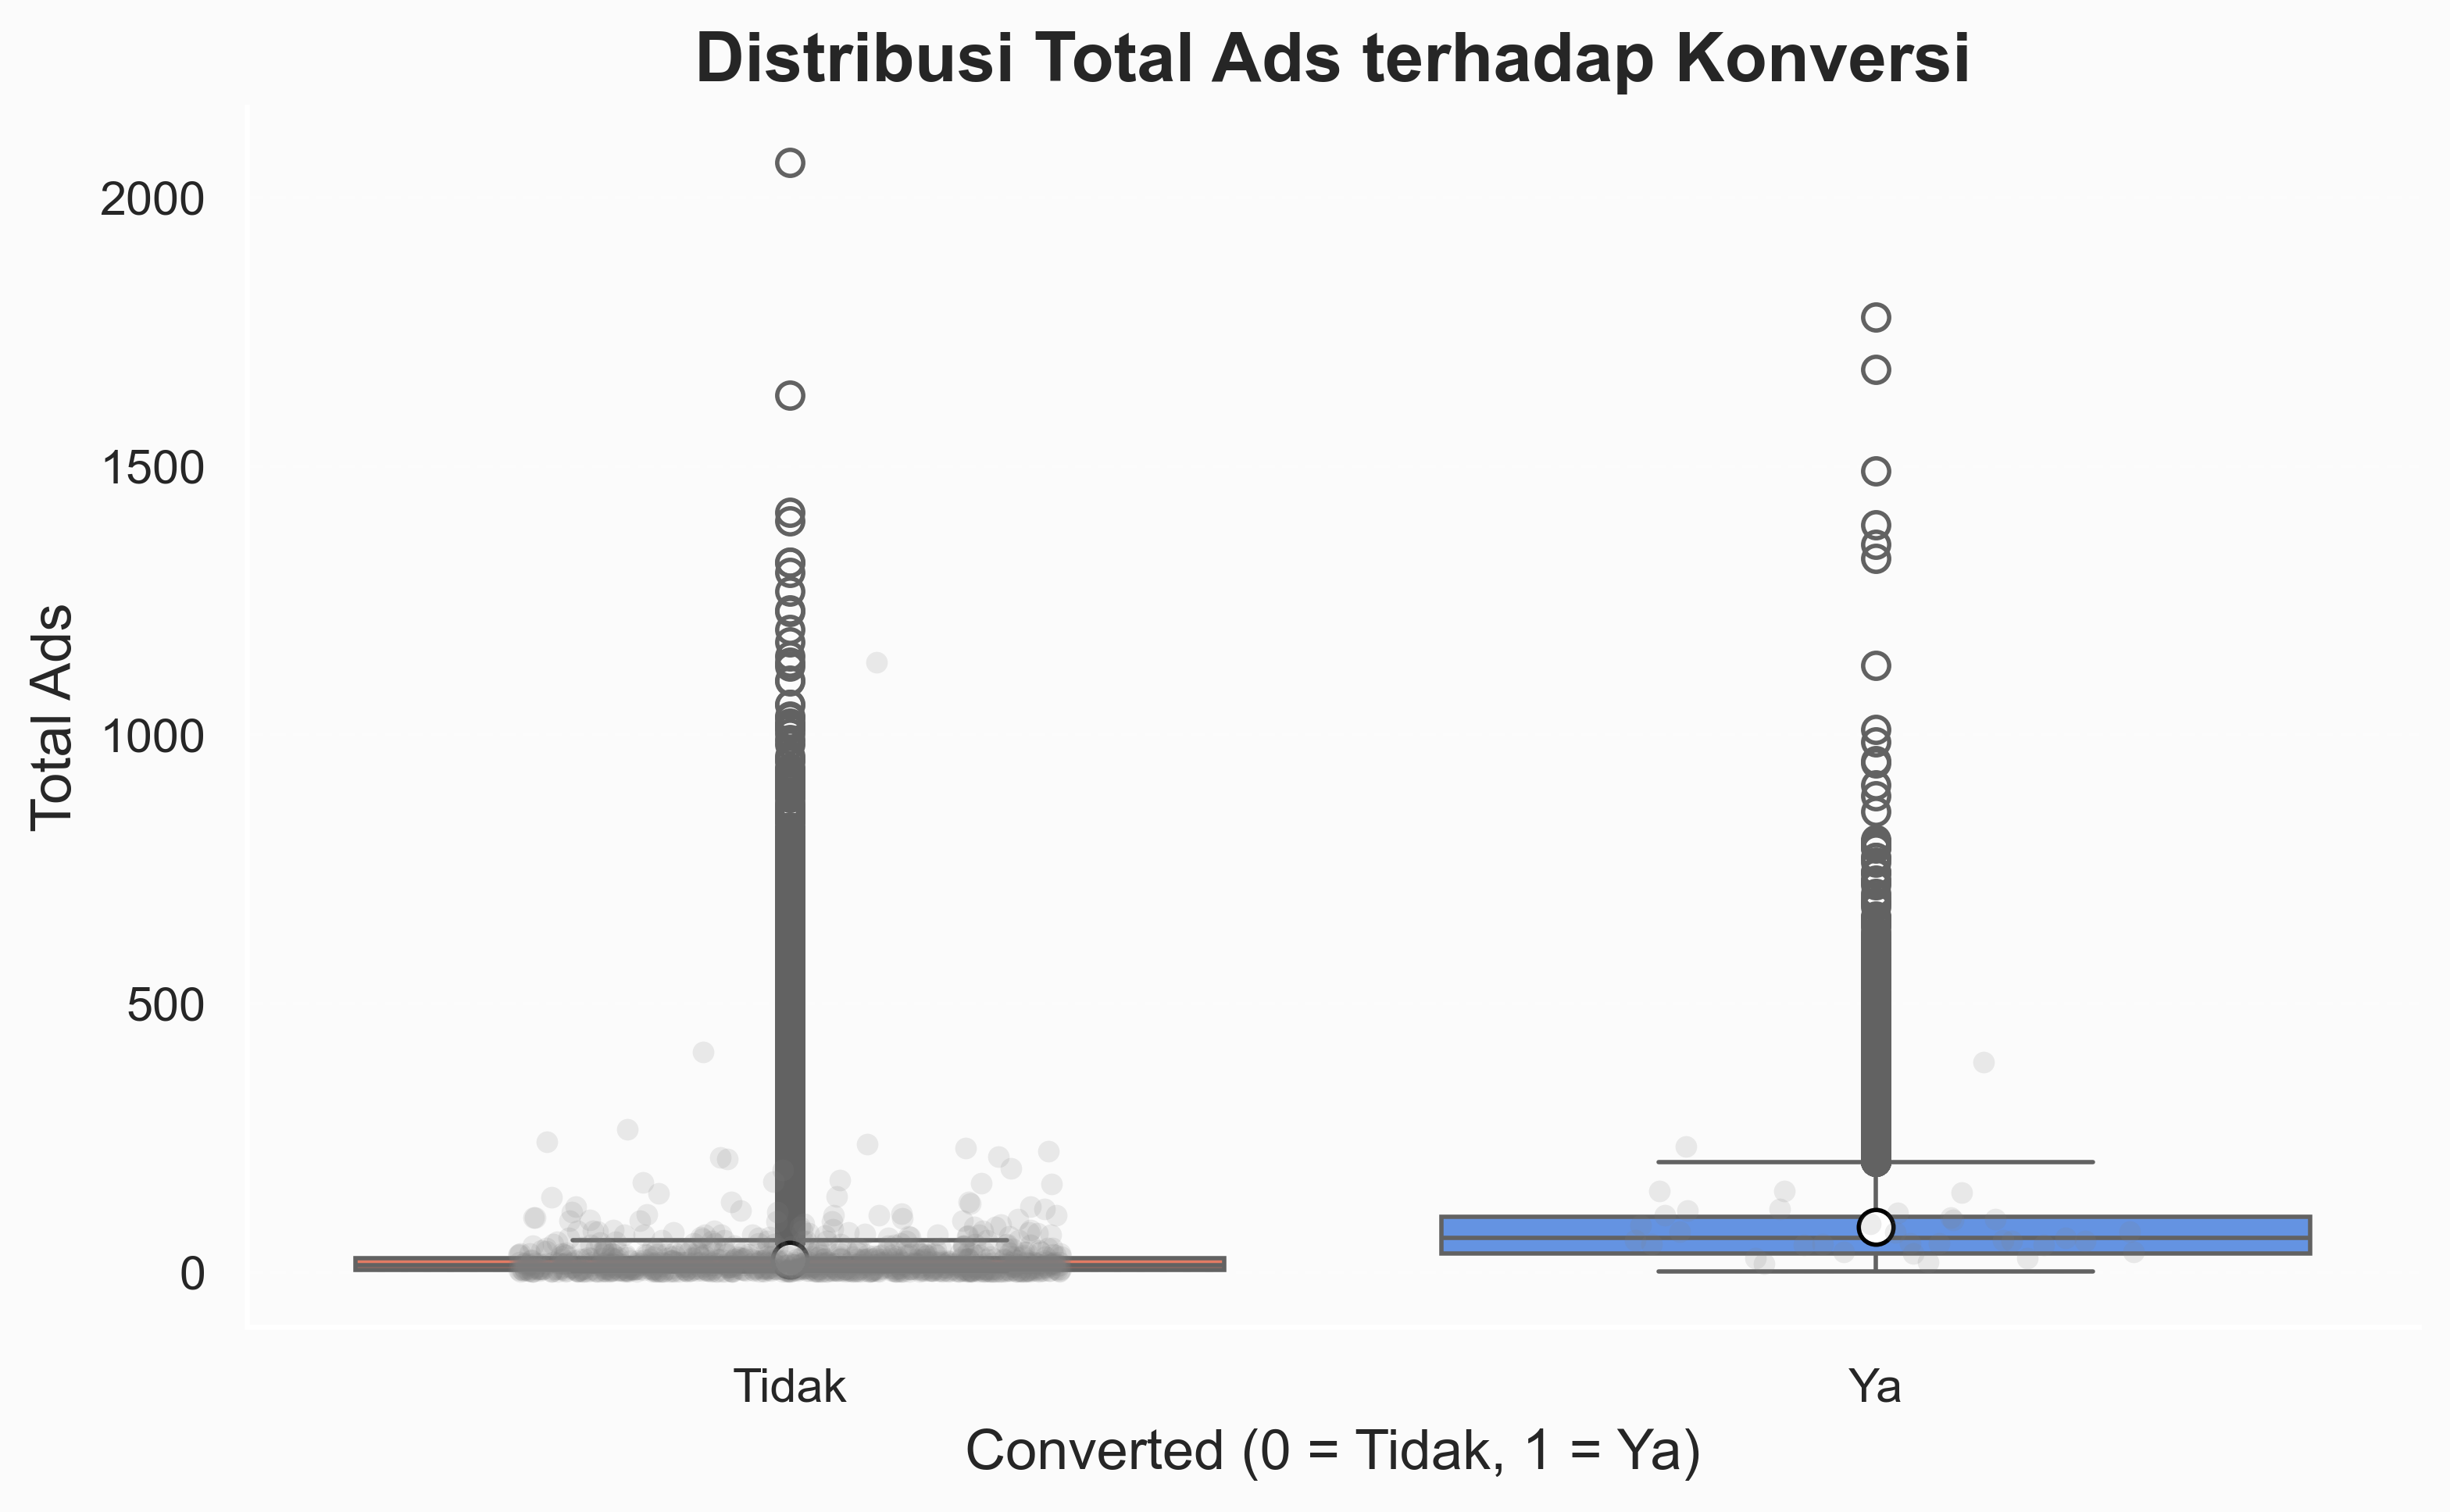

In [7]:
# Boxplot Total Ads vs Converted
plt.figure(figsize=(8, 5))
sns.boxplot(
    x='converted', 
    y='total ads', 
    data=df_asli, 
    palette=['#F76E4F', '#4F8EF7'],
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"8"})
sns.stripplot(
    x='converted', 
    y='total ads', 
    data=df_asli.sample(1000, random_state=42), # tampilkan sebagian data untuk kejelasan
    color='gray', 
    alpha=0.15, 
    jitter=0.25)
plt.title("Distribusi Total Ads terhadap Konversi", fontsize=16, fontweight='bold')
plt.xlabel("Converted (0 = Tidak, 1 = Ya)", fontsize=13)
plt.ylabel("Total Ads", fontsize=13)
plt.xticks([0, 1], ['Tidak', 'Ya'])
plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

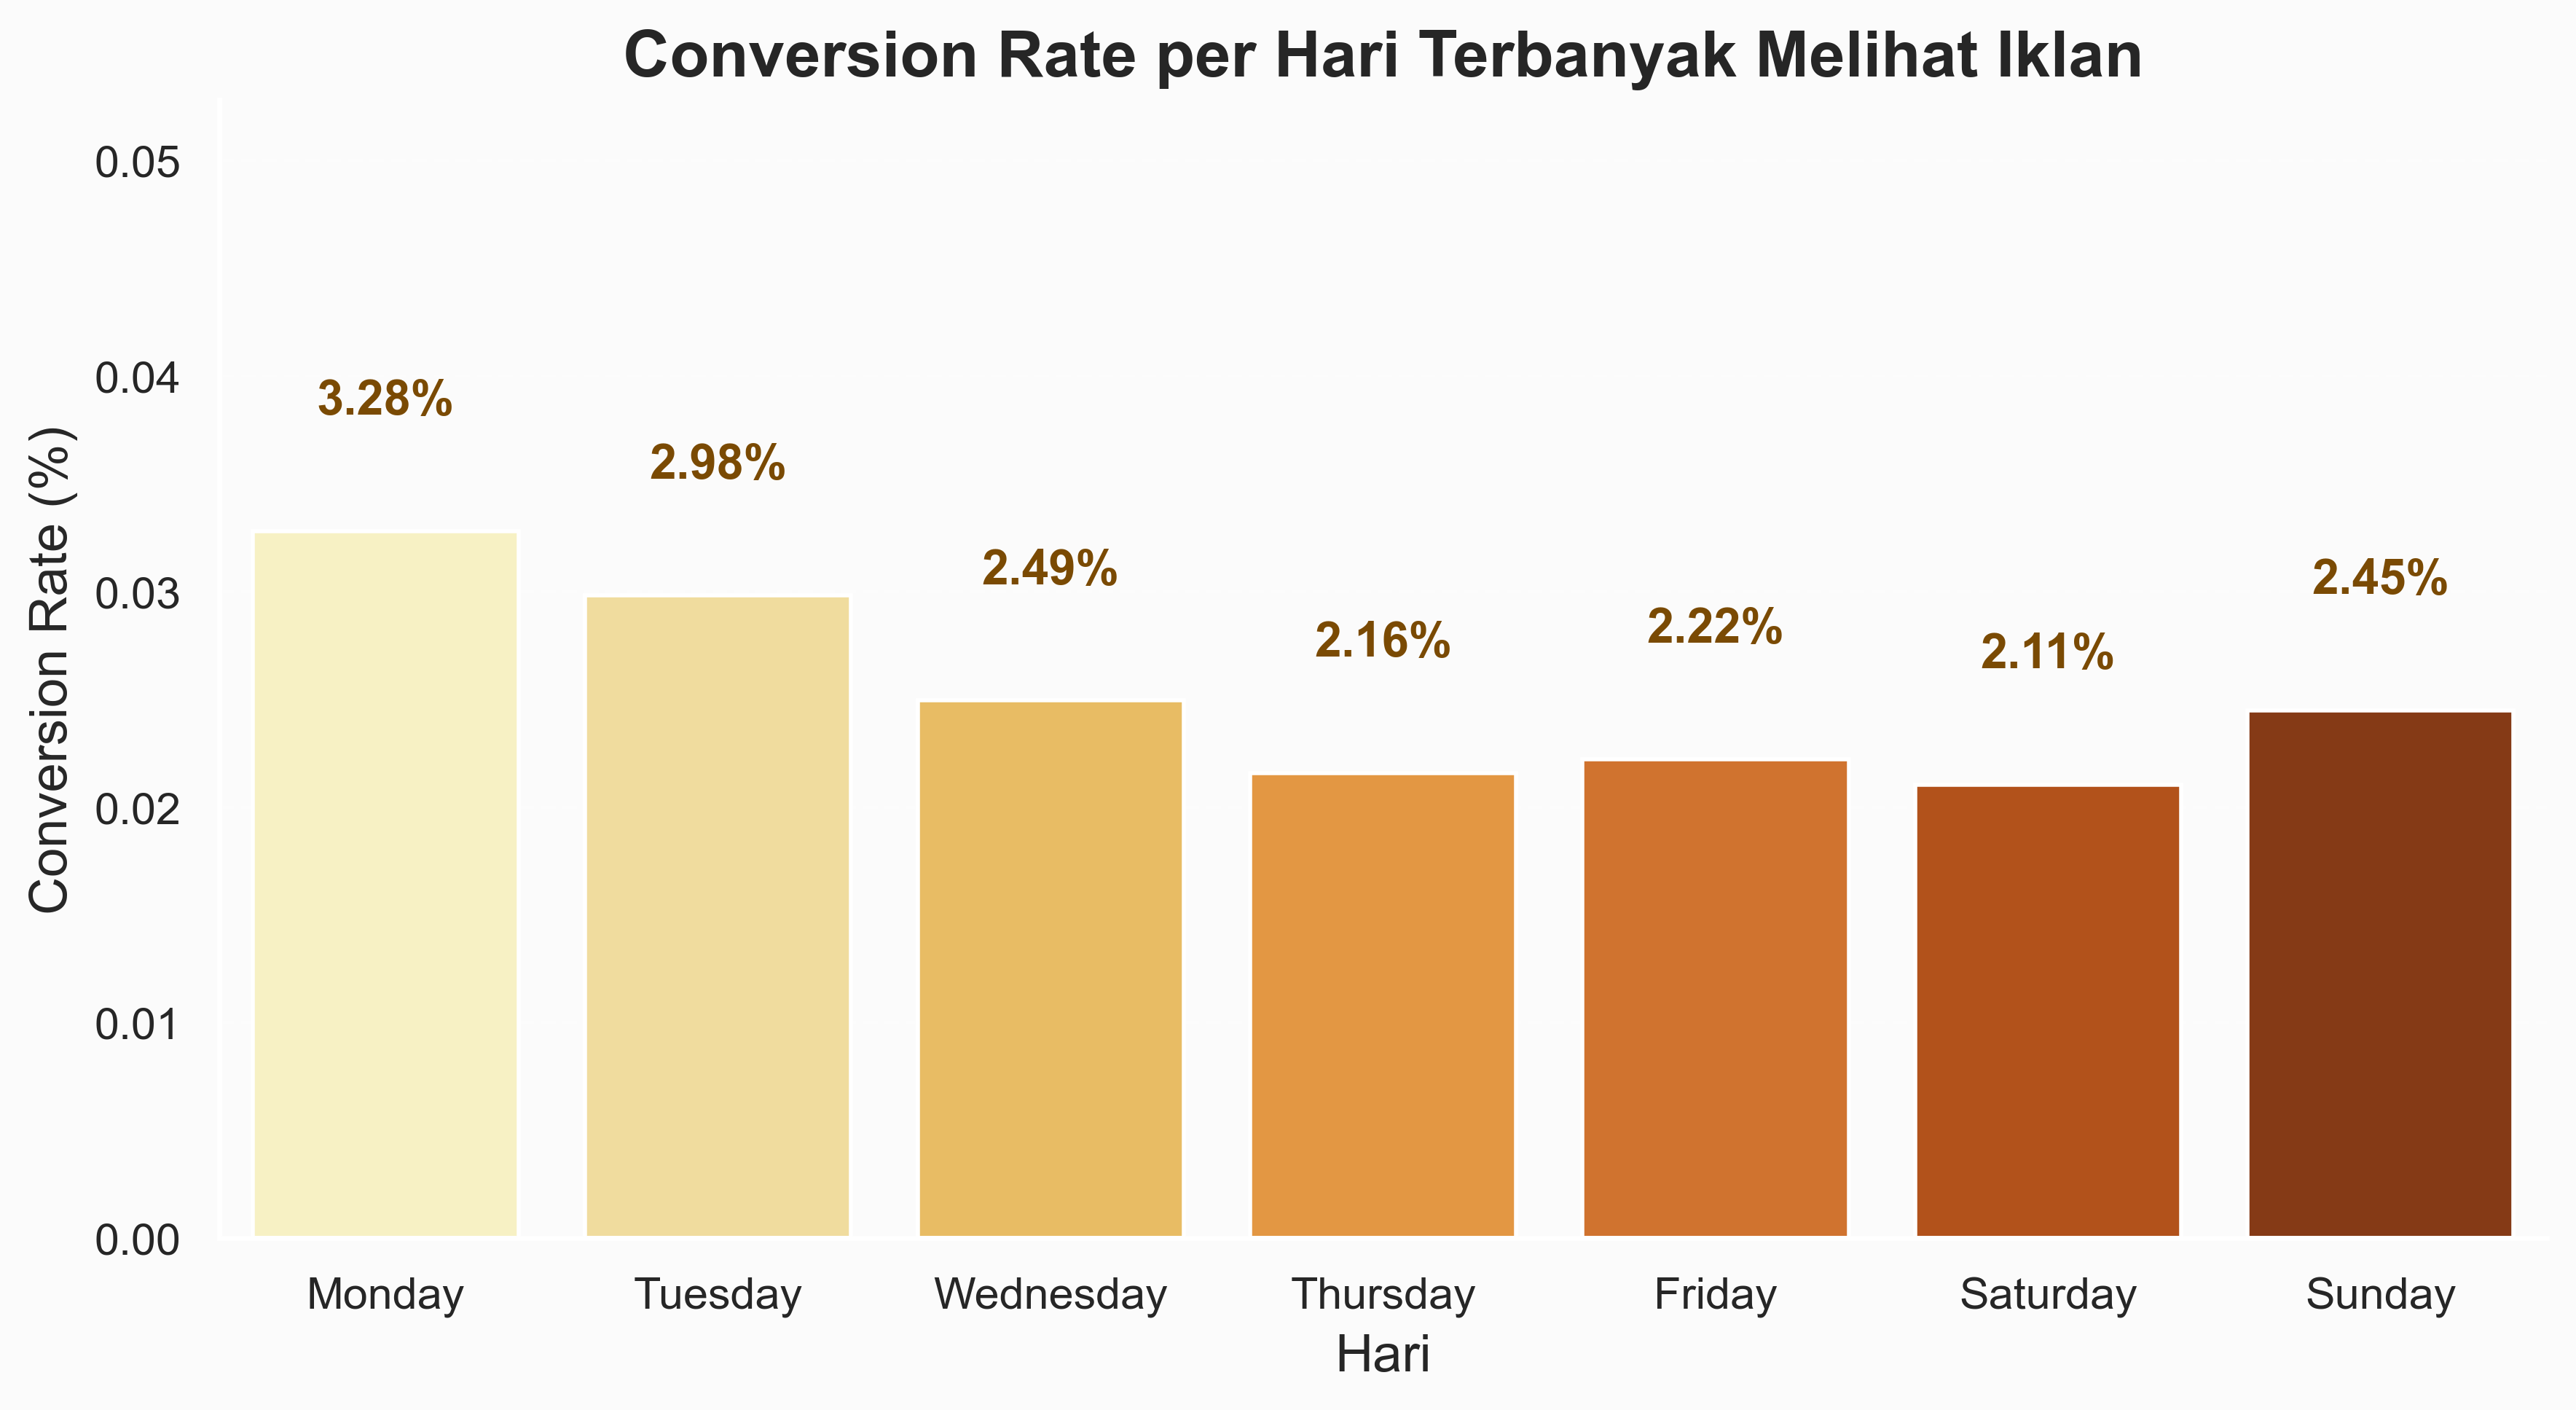

In [8]:
# Conversion Rate berdasarkan Hari
if 'most ads day' in df_asli.columns:
    day_conv = df_asli.groupby('most ads day')['converted'].mean().reset_index()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    plt.figure(figsize=(9, 5))
    palette = sns.color_palette("YlOrBr", n_colors=len(day_order))
    ax = sns.barplot(
        x='most ads day',
        y='converted',
        data=day_conv,
        order=day_order,
        palette=palette)
    for i, row in day_conv.set_index('most ads day').loc[day_order].reset_index().iterrows():
        ax.text(
            i, 
            row['converted'] + 0.005, 
            f"{row['converted']*100:.2f}%", 
            ha='center', 
            va='bottom', 
            fontsize=12, 
            fontweight='bold', 
            color='#7a4a03')
    plt.title("Conversion Rate per Hari Terbanyak Melihat Iklan", fontsize=16, fontweight='bold')
    plt.xlabel("Hari", fontsize=13)
    plt.ylabel("Conversion Rate (%)", fontsize=13)
    plt.ylim(0, day_conv['converted'].max() + 0.02)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    sns.despine()
    plt.tight_layout()
    plt.show()
else:
    print("Kolom 'most ads day' tidak ditemukan di df_asli.")

# A/B Test

## Uji T Independen

**📊 Uji Hipotesis: Perbandingan Rata-rata Konversi**

**🎯 Tujuan**  
Mengetahui apakah terdapat **perbedaan signifikan dalam tingkat konversi** antara pengguna yang melihat iklan (**Ad Group**) dan yang melihat pengumuman layanan publik (**PSA Group**).

---

**🧪 Hipotesis Statistik**

- **H₀ (Hipotesis Nol):**  
  Tidak ada perbedaan rata-rata konversi antara grup `ad` dan grup `psa`.  

- **H₁ (Hipotesis Alternatif):**  
  Terdapat perbedaan rata-rata konversi antara grup `ad` dan grup `psa`.  

---

**📘 Jenis Uji: Independent Samples T-Test**

---

**📌 Kriteria Keputusan**

- Jika **p-value < 0.05**, maka **tolak H₀** → ada perbedaan signifikan.
- Jika **p-value ≥ 0.05**, maka **gagal tolak H₀** → tidak cukup bukti untuk menyatakan perbedaan signifikan.

In [9]:
ad_group = df_asli[df_asli['test group'] == 'ad']['converted'].astype(int)
psa_group = df_asli[df_asli['test group'] == 'psa']['converted'].astype(int)
t_stat, p_value = ttest_ind(ad_group, psa_group, equal_var=False)

mean_ad = ad_group.mean()
mean_psa = psa_group.mean()

print("📊 Hasil Independent Samples T-Test :\n")
print(f"Mean Conversion Rate - Ad Group  : {mean_ad:.4%}")
print(f"Mean Conversion Rate - PSA Group : {mean_psa:.4%}")
print(f"\nT-Statistic                      : {t_stat:.4f}")
print(f"P-Value                          : {p_value:.4e}")

alpha = 0.05
if p_value < alpha:
    print("\n📌 Keputusan: Tolak H0 (terdapat perbedaan signifikan antara grup iklan dan PSA).")
else:
    print("\n📌 Keputusan: Gagal tolak H0 (tidak cukup bukti untuk menyatakan terdapat perbedaan signifikan).")

📊 Hasil Independent Samples T-Test :

Mean Conversion Rate - Ad Group  : 2.5547%
Mean Conversion Rate - PSA Group : 1.7854%

T-Statistic                      : 8.6572
P-Value                          : 5.1076e-18

📌 Keputusan: Tolak H0 (terdapat perbedaan signifikan antara grup iklan dan PSA).


## Uji Cohen's d

**📏 Ukuran Efek: Cohen’s d pada Perbandingan Konversi**

---

**🎯 Tujuan**  
Mengukur seberapa besar perbedaan rata-rata konversi antara grup iklan (**Ad Group**) dan grup PSA (**PSA Group**) dalam satuan standar deviasi.

---

**📐 Apa itu Cohen’s d?**  
Cohen’s d adalah ukuran efek yang menunjukkan seberapa besar perbedaan rata-rata dua grup dibandingkan dengan variasi data secara keseluruhan.

Secara sederhana:

> *Cohen’s d = (Selisih rata-rata kedua grup) ÷ (Standar deviasi gabungan)*

---

**📊 Interpretasi Cohen’s d**

| Nilai d        | Makna Efek                       |
|----------------|---------------------------------|
| < 0.2          | Efek sangat kecil / dapat diabaikan |
| 0.2 – 0.5      | Efek kecil                      |
| 0.5 – 0.8      | Efek sedang                    |
| ≥ 0.8          | Efek besar                     |

In [10]:
ad_group = df_asli[df_asli['test group'] == 'ad']['converted'].astype(int)
psa_group = df_asli[df_asli['test group'] == 'psa']['converted'].astype(int)

mean_diff = ad_group.mean() - psa_group.mean()
n1, n2 = len(ad_group), len(psa_group)
var1, var2 = ad_group.var(ddof=1), psa_group.var(ddof=1)
pooled_std = np.sqrt(((n1 - 1)*var1 + (n2 - 1)*var2) / (n1 + n2 - 2))
cohen_d = mean_diff / pooled_std

def interpret_d(d):
    if abs(d) < 0.2:
        return 'Efek sangat kecil/dapat diabaikan'
    elif abs(d) < 0.5:
        return 'Efek kecil'
    elif abs(d) < 0.8:
        return 'Efek sedang'
    else:
        return 'Efek besar'

print("\n📏 Effect Size (Cohen's d) untuk Perbandingan Konversi:")
print(f"Rata-rata konversi grup Ad  : {ad_group.mean():.4%}")
print(f"Rata-rata konversi grup PSA : {psa_group.mean():.4%}")
print(f"Selisih rata-rata           : {mean_diff:.4%}")
print(f"Pooled Std Dev              : {pooled_std:.6f}")
print(f"Cohen's d                   : {cohen_d:.4f} → {interpret_d(cohen_d)}")


📏 Effect Size (Cohen's d) untuk Perbandingan Konversi:
Rata-rata konversi grup Ad  : 2.5547%
Rata-rata konversi grup PSA : 1.7854%
Selisih rata-rata           : 0.7692%
Pooled Std Dev              : 0.156843
Cohen's d                   : 0.0490 → Efek sangat kecil/dapat diabaikan


## Anova 1 Arah

**📊 Uji ANOVA Satu Arah: Total Ads Berdasarkan Hari Puncak Iklan**

---

**🎯 Tujuan:**  
Mengetahui apakah terdapat **perbedaan rata-rata jumlah iklan yang dilihat (`total ads`)** secara signifikan antar hari puncak penayangan iklan (`most ads day`).

---

**🧪 Hipotesis Statistik:**

- **H0 (Hipotesis Nol):** Tidak ada perbedaan rata-rata `total ads` antar hari.  
- **H1 (Hipotesis Alternatif):** Terdapat paling tidak satu hari dengan rata-rata `total ads` yang berbeda.

---

**🔎 Uji Lanjutan: Tukey's HSD**

Jika hasil ANOVA menunjukkan **perbedaan signifikan**, maka dilakukan uji lanjutan menggunakan **Tukey’s Honest Significant Difference (HSD)** untuk mengetahui **pasangan hari mana yang berbeda secara signifikan**.

In [11]:
df = df_asli
groups = [df[df['most ads day'] == day]['total ads'] for day in sorted(df['most ads day'].unique())]
group_names = sorted(df['most ads day'].unique())

# ----- ANOVA Satu Arah -----
N = len(df)
k = len(groups)
means = [g.mean() for g in groups]
grand_mean = df['total ads'].mean()

# ----- Jumlah Kuadrat -----
SSB = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
SSW = sum(((g - g.mean())**2).sum() for g in groups)
SST = ((df['total ads'] - grand_mean)**2).sum()

# ----- Derajat Bebas -----
df_between = k - 1
df_within = N - k
df_total = N - 1

# ----- Kuadrat Tengah -----
MSB = SSB / df_between
MSW = SSW / df_within

# ----- F-Hitung -----
F = MSB / MSW

# ----- P-Value -----
p_value = 1 - f.cdf(F, df_between, df_within)

# ----- Tabel ANOVA -----
anova_table = pd.DataFrame({
    'Sumber Keragaman': ['Antar Kelompok', 'Dalam Kelompok', 'Total'],
    'Jumlah Kuadrat': [SSB, SSW, SST],
    'Derajat Bebas': [df_between, df_within, df_total],
    'Kuadrat Tengah': [MSB, MSW, '—'],
    'F Hitung': [F, '—', '—'],
    'P-Value': [p_value, '—', '—']})

anova_table['Jumlah Kuadrat'] = anova_table['Jumlah Kuadrat'].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)
anova_table['Kuadrat Tengah'] = anova_table['Kuadrat Tengah'].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)
anova_table['F Hitung'] = anova_table['F Hitung'].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)
anova_table['P-Value'] = anova_table['P-Value'].apply(lambda x: f"{x:.4e}" if isinstance(x, float) else x)
print("\n📋 Tabel Analisis Ragam (ANOVA) Satu Arah untuk Total Ads berdasarkan Hari\n")
print(anova_table.to_string(index=False))

# Kesimpulan
alpha = 0.05
print("\n📌 Kesimpulan:")
if p_value < alpha:
    print(f"P-Value = {p_value:.4e} < {alpha}, maka Tolak H0.")
    print("Artinya, terdapat perbedaan rata-rata 'total ads' yang taraf nyata antar hari puncak iklan.")
else:
    print(f"P-Value = {p_value:.4e} ≥ {alpha}, maka gagal tolak H0.")
    print("Artinya, tidak terdapat perbedaan rata-rata 'total ads' yang taraf nyata antar hari puncak iklan.")


📋 Tabel Analisis Ragam (ANOVA) Satu Arah untuk Total Ads berdasarkan Hari

Sumber Keragaman  Jumlah Kuadrat  Derajat Bebas Kuadrat Tengah F Hitung    P-Value
  Antar Kelompok     577291.7649              6     96215.2942  50.3731 1.1102e-16
  Dalam Kelompok 1123291809.7762         588094      1910.0549        —          —
           Total 1123869101.5411         588100              —        —          —

📌 Kesimpulan:
P-Value = 1.1102e-16 < 0.05, maka Tolak H0.
Artinya, terdapat perbedaan rata-rata 'total ads' yang taraf nyata antar hari puncak iklan.


### Tukey (Beda Nyata Jujur)

**🔎 Uji Lanjutan: Tukey's Honest Significant Difference (Beda Nyata Jujur)**

---

**📌 Mengapa Dilakukan Uji Tukey?**  
Setelah dilakukan uji ANOVA satu arah, hasil menunjukkan bahwa **terdapat perbedaan rata-rata jumlah iklan yang ditampilkan (`total ads`) secara signifikan antar hari puncak penayangan iklan (`most ads day`)**, dengan P-Value < 0.05.

Namun, **ANOVA hanya memberitahu bahwa ada perbedaan**, **bukan hari mana yang berbeda**. Oleh karena itu, dibutuhkan uji lanjutan untuk:

---

Dengan demikian, **uji Beda Nyata Jujur digunakan sebagai kelanjutan dari ANOVA** untuk **mengidentifikasi letak perbedaan antar kelompok hari** dalam konteks intensitas penayangan iklan.


In [12]:
tukey_result = pairwise_tukeyhsd(
    endog=df_asli['total ads'],        
    groups=df_asli['most ads day'],    
    alpha=0.05)

tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], 
                        columns=tukey_result.summary().data[0])
tukey_df.columns = ['Hari 1', 'Hari 2', 'Selisih Rata-rata', 'p-value', 
                    'Interval Bawah', 'Interval Atas', 'Signifikan?']

tukey_df['Selisih Rata-rata'] = tukey_df['Selisih Rata-rata'].astype(float).round(2)
tukey_df['p-value'] = tukey_df['p-value'].astype(float).apply(lambda x: f"{x:.4f}")
tukey_df['Taraf Nyata'] = tukey_df['Signifikan?'].map({True: '✅ Ya', False: '❌ Tidak'})
print("\n📋 Tabel Hasil Tukey's HSD:")
print(tukey_df.to_string(index=False))


📋 Tabel Hasil Tukey's HSD:
  Hari 1    Hari 2  Selisih Rata-rata p-value  Interval Bawah  Interval Atas  Signifikan? Taraf Nyata
  Friday    Monday              -1.28  0.0000         -1.8919        -0.6754         True        ✅ Ya
  Friday  Saturday              -1.38  0.0000         -2.0030        -0.7659         True        ✅ Ya
  Friday    Sunday              -2.21  0.0000         -2.8198        -1.5971         True        ✅ Ya
  Friday  Thursday              -3.18  0.0000         -3.7992        -2.5673         True        ✅ Ya
  Friday   Tuesday              -2.69  0.0000         -3.3140        -2.0593         True        ✅ Ya
  Friday Wednesday              -2.07  0.0000         -2.6930        -1.4528         True        ✅ Ya
  Monday  Saturday              -0.10  0.9992         -0.7286         0.5268        False     ❌ Tidak
  Monday    Sunday              -0.92  0.0002         -1.5454        -0.3043         True        ✅ Ya
  Monday  Thursday              -1.90  0.0000         

## Anova 2 Arah

**📊 ANOVA Dua Arah: Pengaruh Grup dan Waktu Terhadap Konversi**

Untuk memahami bagaimana faktor **jenis grup iklan** (`test group`) dan **waktu paparan iklan** (seperti `most ads day` atau `most ads hour`) memengaruhi **tingkat konversi pengguna**, dilakukan **ANOVA dua arah**. Uji ini berguna tidak hanya untuk menguji efek masing-masing faktor secara terpisah (efek utama), tetapi juga untuk mengevaluasi apakah terdapat **interaksi** antara kedua faktor tersebut—misalnya, apakah efektivitas iklan berbeda tergantung hari atau jam iklan ditampilkan.

---

**🧪 Hipotesis Statistik**

**Efek Utama: `test group`**
- **H₀**: Tidak ada perbedaan konversi antara grup `ad` dan `psa`.  
- **H₁**: Terdapat perbedaan konversi antara grup `ad` dan `psa`.

**Efek Utama: `most ads day` / `most ads hour`**
- **H₀**: Tidak ada perbedaan konversi antar hari/jam puncak iklan.  
- **H₁**: Terdapat perbedaan konversi antar hari/jam puncak iklan.

**Interaksi: `test group × waktu`**
- **H₀**: Tidak ada pengaruh interaksi antara grup dan waktu terhadap konversi.  
- **H₁**: Terdapat pengaruh interaksi antara grup dan waktu terhadap konversi.

---

Apabila ditemukan pengaruh yang taraf nyata, maka dapat dilanjutkan dengan uji post-hoc seperti **Tukey Beda Nyata Jujur** untuk mengetahui kombinasi mana yang berbeda secara nyata.

In [13]:
df_asli['test group'] = df_asli['test group'].astype('category')
df_asli['most ads day'] = df_asli['most ads day'].astype('category')
df_asli['most ads hour'] = df_asli['most ads hour'].astype('category')

# ANOVA 2 arah: test group × most ads day
model_day = ols('converted_int ~ C(Q("test group")) * C(Q("most ads day"))', data=df_asli).fit()
anova_day = sm.stats.anova_lm(model_day, typ=2)

# ANOVA 2 arah: test group × most ads hour
model_hour = ols('converted_int ~ C(Q("test group")) * C(Q("most ads hour"))', data=df_asli).fit()
anova_hour = sm.stats.anova_lm(model_hour, typ=2)

print("📊 Two-Way ANOVA: Interaksi antara Grup dan Hari Puncak Iklan")
display(anova_day)
print("\n📊 Two-Way ANOVA: Interaksi antara Grup dan Jam Puncak Iklan")
display(anova_hour)

📊 Two-Way ANOVA: Interaksi antara Grup dan Hari Puncak Iklan


,sum_sq,df,F,PR(>F)
"C(Q(""test group""))",1.317240,1.0,53.584867,2.479734e-13
"C(Q(""most ads day""))",10.068857,6.0,68.266244,2.589796e-85
"C(Q(""test group"")):C(Q(""most ads day""))",0.430494,6.0,2.918723,7.574369e-03
Residual,14456.543895,588087.0,NaN,NaN



📊 Two-Way ANOVA: Interaksi antara Grup dan Jam Puncak Iklan


,sum_sq,df,F,PR(>F)
"C(Q(""test group""))",1.352934,1.0,55.035153,1.185513e-13
"C(Q(""most ads hour""))",10.614321,23.0,18.772751,5.347616e-77
"C(Q(""test group"")):C(Q(""most ads hour""))",0.270154,23.0,0.477801,9.832950e-01
Residual,14456.158771,588053.0,NaN,NaN


In [14]:
def interpret_anova_table(anova_table, faktor1, faktor2, label):
    results = []

    effects = {
        f"C(Q(\"{faktor1}\"))": f"Efek Utama: {faktor1}",
        f"C(Q(\"{faktor2}\"))": f"Efek Utama: {faktor2}",
        f"C(Q(\"{faktor1}\")):C(Q(\"{faktor2}\"))": f"Interaksi: {faktor1} × {faktor2}"}
    for key, name in effects.items():
        if key in anova_table.index:
            p_val = anova_table.loc[key, 'PR(>F)']
            results.append({
                'Efek': name,
                'p-value': round(p_val, 4),
                'Keputusan': 'Tolak H0' if p_val < 0.05 else 'Gagal Tolak H0',
                'Signifikansi': 'Signifikan' if p_val < 0.05 else 'Tidak Signifikan'})
    hasil_df = pd.DataFrame(results)
    print(f"\n📘 Interpretasi ANOVA 2 Arah: {label}")
    display(hasil_df)


def rekap_lanjut_tukey(anova_tables_info):
    hasil_rekap = []
    for anova_table, faktor1, faktor2, label in anova_tables_info:
        interaksi = f"C(Q(\"{faktor1}\")):C(Q(\"{faktor2}\"))"
        signifikan_interaksi = (
            interaksi in anova_table.index and 
            anova_table.loc[interaksi, 'PR(>F)'] < 0.05)
        hasil_rekap.append({
            "Uji ANOVA": label,
            "Efek Interaksi Signifikan": "Ya" if signifikan_interaksi else "Tidak",
            "Lanjut Tukey HSD": "✅ Lanjut" if signifikan_interaksi else "❌ Tidak Perlu"})
    df_rekap = pd.DataFrame(hasil_rekap)
    print("\n📊 Rangkuman Lanjutan Tukey HSD berdasarkan Efek Interaksi:")
    display(df_rekap)

In [15]:
interpret_anova_table(anova_day, 'test group', 'most ads day', 'Grup × Hari Puncak Iklan')
interpret_anova_table(anova_hour, 'test group', 'most ads hour', 'Grup × Jam Puncak Iklan')

rekap_lanjut_tukey([
    (anova_day, 'test group', 'most ads day', 'Grup × Hari Puncak Iklan'),
    (anova_hour, 'test group', 'most ads hour', 'Grup × Jam Puncak Iklan')])


📘 Interpretasi ANOVA 2 Arah: Grup × Hari Puncak Iklan


,Efek,p-value,Keputusan,Signifikansi
0,Efek Utama: test group,0.0000,Tolak H0,Signifikan
1,Efek Utama: most ads day,0.0000,Tolak H0,Signifikan
2,Interaksi: test group × most ads day,0.0076,Tolak H0,Signifikan



📘 Interpretasi ANOVA 2 Arah: Grup × Jam Puncak Iklan


,Efek,p-value,Keputusan,Signifikansi
0,Efek Utama: test group,0.0000,Tolak H0,Signifikan
1,Efek Utama: most ads hour,0.0000,Tolak H0,Signifikan
2,Interaksi: test group × most ads hour,0.9833,Gagal Tolak H0,Tidak Signifikan



📊 Rangkuman Lanjutan Tukey HSD berdasarkan Efek Interaksi:


,Uji ANOVA,Efek Interaksi Signifikan,Lanjut Tukey HSD
0,Grup × Hari Puncak Iklan,Ya,✅ Lanjut
1,Grup × Jam Puncak Iklan,Tidak,❌ Tidak Perlu


### Tukey (Beda Nyata Jujur)

In [16]:
df_asli['group_interaction'] = df_asli['test group'].astype(str) + " × " + df_asli['most ads day'].astype(str)

tukey_result = pairwise_tukeyhsd(endog=df_asli['converted_int'], groups=df_asli['group_interaction'], alpha=0.05)
tukey_df = pd.DataFrame(tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
tukey_df['Taraf Nyata'] = tukey_df['reject'].map({True: '✅ Ya', False: '❌ Tidak'})

tukey_df = tukey_df.rename(columns={
    'group1': 'Grup 1',
    'group2': 'Grup 2',
    'meandiff': 'Selisih Rata-rata',
    'p-adj': 'p-value',
    'lower': 'Interval Bawah',
    'upper': 'Interval Atas',
    'reject': 'Signifikan?'})

tukey_df = tukey_df[['Grup 1', 'Grup 2', 'Selisih Rata-rata', 'p-value', 'Interval Bawah', 'Interval Atas', 'Signifikan?', 'Taraf Nyata']]
tukey_df['Selisih Rata-rata'] = tukey_df['Selisih Rata-rata'].round(2)
tukey_df['p-value'] = tukey_df['p-value'].apply(lambda x: f"{x:.4f}")
tukey_df['Interval Bawah'] = tukey_df['Interval Bawah'].round(4)
tukey_df['Interval Atas'] = tukey_df['Interval Atas'].round(4)
print("📋 Tabel Hasil Tukey's HSD (Interaksi test group × most ads day):")
display(tukey_df)

📋 Tabel Hasil Tukey's HSD (Interaksi test group × most ads day):


,Grup 1,Grup 2,Selisih Rata-rata,p-value,Interval Bawah,Interval Atas,Signifikan?,Taraf Nyata
0,ad × Friday,ad × Monday,0.01,0.0000,0.0082,0.0133,True,✅ Ya
1,ad × Friday,ad × Saturday,-0.00,0.9663,-0.0037,0.0014,False,❌ Tidak
2,ad × Friday,ad × Sunday,0.00,0.2042,-0.0004,0.0047,False,❌ Tidak
3,ad × Friday,ad × Thursday,-0.00,0.9985,-0.0034,0.0017,False,❌ Tidak
4,ad × Friday,ad × Tuesday,0.01,0.0000,0.0054,0.0106,True,✅ Ya
...,...,...,...,...,...,...,...,...
86,psa × Sunday,psa × Tuesday,-0.01,0.9655,-0.0198,0.0075,False,❌ Tidak
87,psa × Sunday,psa × Wednesday,-0.00,0.9939,-0.0179,0.0082,False,❌ Tidak
88,psa × Thursday,psa × Tuesday,-0.01,0.9670,-0.0187,0.0071,False,❌ Tidak
89,psa × Thursday,psa × Wednesday,-0.00,0.9948,-0.0167,0.0078,False,❌ Tidak


# Uji Khi-Kuadrat

Uji Chi-Squared digunakan untuk menguji **independensi** antara dua variabel kategorik.  

**Tujuan:**  
Menentukan apakah ada hubungan yang signifikan secara statistik antara dua variabel kategori, misalnya antara grup uji dan status konversi.

**Hipotesis:**  
- H0: Variabel-variabel tersebut **independen** (tidak ada hubungan).  
- H1: Variabel-variabel tersebut **tidak independen** (ada hubungan).

**Interpretasi:**  
- Jika nilai *p-value* < 0.05, maka tolak H0 → ada hubungan signifikan antara variabel.  
- Jika *p-value* ≥ 0.05, maka gagal tolak H0 → tidak ada bukti hubungan signifikan.

**Contoh aplikasi:**  
Menguji apakah jenis grup (misal: "ad" vs "psa") memengaruhi tingkat konversi pengguna.

---

In [17]:
contingency_table = pd.crosstab(df_asli['converted'], df_asli['test group'])
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)

print("\n📊 Hasil Uji Chi-Squared: Hubungan antara Status Konversi dan Grup Pengujian\n")
print("Tabel Kontingensi:")
display(contingency_table)

print(f"\n➡️ Chi2 Statistic : {chi2:.4f}")
print(f"➡️ Degrees of Freedom (df) : {dof}")
print(f"➡️ P-Value : {p_chi2:.4e}")

print("\n📌 Interpretasi Singkat:")
if p_chi2 < 0.05:
    print("- Nilai p-value sangat kecil (< 0.05), sehingga kita tolak hipotesis nol (H0).")
    print("- Artinya, terdapat hubungan signifikan antara grup uji dan tingkat konversi.")
    print("- Dengan kata lain, jenis grup (iklan vs PSA) berpengaruh terhadap peluang konversi.")
else:
    print("- Nilai p-value tidak cukup kecil (≥ 0.05), sehingga gagal tolak hipotesis nol (H0).")
    print("- Tidak ditemukan bukti hubungan signifikan antara grup uji dan tingkat konversi.")


📊 Hasil Uji Chi-Squared: Hubungan antara Status Konversi dan Grup Pengujian

Tabel Kontingensi:


test group,ad,psa
converted,,
False,550154,23104
True,14423,420



➡️ Chi2 Statistic : 54.0058
➡️ Degrees of Freedom (df) : 1
➡️ P-Value : 1.9990e-13

📌 Interpretasi Singkat:
- Nilai p-value sangat kecil (< 0.05), sehingga kita tolak hipotesis nol (H0).
- Artinya, terdapat hubungan signifikan antara grup uji dan tingkat konversi.
- Dengan kata lain, jenis grup (iklan vs PSA) berpengaruh terhadap peluang konversi.


# 📊 Insight Utama & Simpulan Bisnis (Lengkap)

## Insight Data & Hasil Analisis

### 1. **Perbedaan Tingkat Konversi antara Grup Iklan dan PSA**
- **Uji T dan Chi-Square:**  
  Hasil uji t (t = 8.66, p-value ≈ 1.1e-16) dan uji chi-square (chi2 = 54.01, p-value ≈ 2.0e-13) menunjukkan **perbedaan signifikan** tingkat konversi antara grup yang melihat iklan (`ad`) dan grup PSA (`psa`).  
  - **Rata-rata konversi grup ad:** 2.55%  
  - **Rata-rata konversi grup PSA:** 1.79%  
  - **Selisih rata-rata:** 0.77%  
  - **Interpretasi:** Grup iklan secara statistik dan praktis lebih efektif dalam mendorong konversi dibanding PSA.

### 2. **Ukuran Efek (Cohen’s d)**
- **Nilai Cohen’s d:** 0.049  
  - **Interpretasi:** Efek perbedaan konversi antara grup ad dan PSA **sangat kecil** secara statistik (d < 0.2), namun tetap relevan secara bisnis mengingat skala data yang besar dan potensi revenue yang meningkat.

### 3. **Pengaruh Waktu Paparan Iklan (ANOVA Satu Arah)**
- **ANOVA satu arah pada `total ads` berdasarkan `most ads day`:**
  - **F = 50.37, p-value ≈ 1.1e-16**  
  - **Interpretasi:** Terdapat **perbedaan signifikan** rata-rata jumlah iklan yang dilihat antar hari puncak penayangan.
  - **Rata-rata total ads per hari:**
    | Hari       | Rata-rata Total Ads |
    |------------|---------------------|
    | Friday     | 26.61               |
    | Monday     | 25.33               |
    | Saturday   | 25.23               |
    | Sunday     | 24.40               |
    | Thursday   | 23.43               |
    | Tuesday    | 23.93               |
    | Wednesday  | 24.54               |
  - **Hari dengan paparan tertinggi:** Friday, Monday, Saturday  
  - **Hari dengan paparan terendah:** Thursday, Tuesday, Wednesday

### 4. **Analisis Lanjutan: Tukey HSD**
- **Tukey HSD** mengidentifikasi **pasangan hari** yang berbeda signifikan:
  - **Friday vs Tuesday** dan **Friday vs Thursday**: Friday secara signifikan lebih tinggi rata-rata paparan iklannya.
  - **Monday vs Thursday** dan **Monday vs Tuesday**: Monday juga lebih tinggi dari Thursday dan Tuesday.
  - **Tidak semua hari berbeda signifikan**; misal, Saturday vs Sunday tidak berbeda nyata.
- **Implikasi:** Penjadwalan iklan pada hari-hari dengan paparan tinggi (Friday, Monday) dapat meningkatkan efektivitas kampanye.

### 5. **Interaksi Grup dan Waktu (ANOVA Dua Arah)**
- **ANOVA dua arah (`test group` × `most ads day`):**
  - **Efek utama test group:** p ≈ 2.5e-13 (**signifikan**)
  - **Efek utama hari:** p ≈ 2.6e-85 (**signifikan**)
  - **Interaksi test group × hari:** p ≈ 7.6e-3 (**signifikan**)
- **ANOVA dua arah (`test group` × `most ads hour`):**
  - **Efek utama test group:** p ≈ 1.2e-13 (**signifikan**)
  - **Efek utama jam:** p ≈ 5.3e-77 (**signifikan**)
  - **Interaksi test group × jam:** p ≈ 0.98 (**tidak signifikan**)
- **Interpretasi:**  
  - **Hari:** Efektivitas grup iklan berbeda tergantung hari penayangan (ada interaksi).
  - **Jam:** Tidak ada interaksi signifikan antara grup dan jam penayangan.

### 6. **Tukey HSD pada Interaksi Grup × Hari**
- **Tukey HSD** pada kombinasi grup × hari menunjukkan:
  - **Beberapa kombinasi grup × hari berbeda signifikan** dalam tingkat konversi.
  - Contoh: `ad × Friday` vs `ad × Tuesday` dan `ad × Friday` vs `ad × Monday` berbeda nyata.
  - **Implikasi:** Kombinasi tertentu (misal, grup ad pada hari Friday) sangat optimal untuk konversi.

### 7. **Hubungan Kategorikal (Chi-Square)**
- **Uji chi-square** memperkuat temuan bahwa **jenis grup (ad vs PSA) berhubungan signifikan dengan tingkat konversi** pengguna.

---

## Simpulan Bisnis & Rekomendasi

- **Kampanye Iklan Terbukti Efektif:**  
  Berdasarkan analisis statistik (uji t, ANOVA, chi-square), kampanye iklan secara signifikan meningkatkan tingkat konversi dibandingkan PSA. Hal ini menegaskan bahwa investasi pada iklan digital memberikan dampak nyata terhadap pencapaian tujuan bisnis.

- **Kontribusi Iklan terhadap Kesuksesan Kampanye:**  
  Selisih konversi antara grup iklan dan PSA, meskipun secara statistik tergolong kecil (Cohen’s d < 0.2), tetap relevan secara bisnis karena skala audiens yang besar. Setiap peningkatan kecil pada conversion rate dapat menghasilkan revenue tambahan yang substansial.

- **Optimalisasi Jadwal Penayangan:**  
  Efektivitas iklan sangat dipengaruhi oleh waktu penayangan. Hari-hari seperti Friday, Monday, dan Saturday terbukti memiliki paparan dan konversi tertinggi. Penjadwalan kampanye pada hari-hari ini dapat memaksimalkan ROI.

- **Segmentasi & Personalisasi:**  
  Terdapat interaksi signifikan antara grup iklan dan hari penayangan. Artinya, strategi pemasaran yang disesuaikan dengan waktu (hari tertentu) dan segmen audiens dapat meningkatkan efektivitas kampanye. Personalisasi konten dan penawaran pada waktu-waktu optimal sangat disarankan.

- **Rekomendasi Strategis:**
  - **Alokasikan anggaran lebih besar pada channel dan waktu yang terbukti efektif.**
  - **Lakukan eksperimen lanjutan (A/B/n test) untuk menguji variasi konten, penempatan, dan waktu penayangan.**
  - **Pantau performa secara real-time dan lakukan penyesuaian dinamis berdasarkan data terbaru.**
  - **Kolaborasi dengan tim brand untuk memastikan pesan iklan tetap konsisten dan relevan dengan target pasar.**

Dengan pendekatan berbasis data dan eksperimen terstruktur, perusahaan dapat mengoptimalkan strategi pemasaran, memperkuat brand, dan meningkatkan efisiensi anggaran untuk pertumbuhan bisnis yang berkelanjutan.

---

**Catatan:**  
- Efek statistik pada skala besar bisa tampak kecil secara numerik, namun berdampak signifikan secara bisnis.
- Kombinasi strategi waktu dan grup iklan sangat penting untuk mengoptimalkan konversi.  
- Rekomendasi didasarkan pada hasil uji statistik dan analisis post-hoc yang komprehensif.